# Pycle demo 1: efficient sketch tuning for GMM fitting
This notebook demonstrates the following features of the `pycle`toolbox: tuning the (frequency sampling pattern of the) sketch from a light "pre-sketch" on a small subset of the dataset, and learning and plotting a GMM distribution. In particular, we will:
0. Generate a synthetic dataset
1. Sketch a small subset of it with a data-independent distribution, and use it to learn the actual frequency sampling pattern we will use to sketch the whole dataset.
2. Learn a Gaussian mixture model from this adapted sketch.

We assume that you have installed `pycle` with `pip` or that you have the `pycle` folder in the same directory as this notebook.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

To demonstrate the toolbox, we generate a simple synthetic dataset, from a Gaussian mixture model in two dimensions.

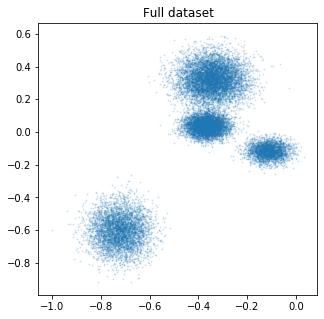

In [2]:
from pycle.utils import generatedataset_GMM

d = 2     # Dimension
K = 4     # Number of Gaussians
n = 20000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
(X,*GT_GMM) = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',balanced=False,isotropic=False) 

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Full dataset")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.show()

In this example, we want to use a random Fourier features sketch, but we don't know beforehand how to draw the frequencies associated with those features (we don't know the associated $\Sigma$ parameter). We thus allow ourselves to oberse a small subset of the dataset ($n_0$ samples, which here correspond to $1\%$ of the obervations) through a smaller, arbitrarily generated "pre-sketch" of size $m_0$. (Without entering into the details[1], know that this is done by iteratively selecting $m_0$ candidate values for $\boldsymbol \omega_j$ according to an arbitrary initial guess for $\Sigma$, compute the associated sketch, then updating $\Sigma$ by fitting a Gaussian curbe to the maximal absolute values of the sketch in $c$ contiguous blocks when ordered as a function of $\|\boldsymbol \omega_j\|$.)

All this is implemented by the `sk.estimate_Sigma` method.

[1] See section 3.3.3 of https://arxiv.org/pdf/1606.02838.pdf.

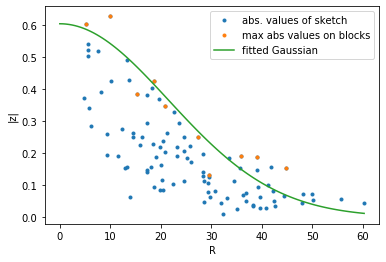

Estimated sigma2_bar:  0.0021668727313067003


In [3]:
import pycle.sketching as sk # import sketching submodule

m0 = 100    # use a pre-sketch of size 100
n0 = n//100 # observe 1% of the dataset to estimata Sigma

Sigma = sk.estimate_Sigma(X,m0,c=10,n0=n0,verbose=1)
print("Estimated sigma2_bar: ",Sigma[0][0])

By putting `verbose=1`, we asked `estimate_Sigma` to plot the 
After this, we can generate the sketch and compress the whole dataset.

In [4]:
m = 20*K*d
Omega = sk.drawFrequencies("FoldedGaussian",d,m,Sigma)

Phi = sk.SimpleFeatureMap("ComplexExponential",Omega)

z = sk.computeSketch(X,Phi)

Let's use this sketch to learn a Gaussian mixture model. Note since `CLOMPR_GMM` is sensible to local optima, we ask it to run 5 independent trials and keep the one that minimizes the objective function (`bestOfRuns=5`).

In [5]:
import pycle.compressive_learning as cl

GMM = cl.CLOMPR_GMM(z,Phi,K,bestOfRuns=5)

print("weights: \n",GMM[0])
print("centers: \n",GMM[1])
print("covariances: \n",GMM[2])

weights: 
 [0.27707703 0.14062491 0.356224   0.22607406]
centers: 
 [[-0.36867255  0.03717084]
 [-0.1152426  -0.11522733]
 [-0.34535954  0.32385343]
 [-0.72340587 -0.60363299]]
covariances: 
 [[[0.00197565 0.        ]
  [0.         0.00166448]]

 [[0.00192653 0.        ]
  [0.         0.00142353]]

 [[0.00485773 0.        ]
  [0.         0.00637531]]

 [[0.00406644 0.        ]
  [0.         0.0083063 ]]]


The returned `GMM` is a tuple containing the weights, centers and covariances of the fitted Gaussians. We can plot the learned model with the `plotGMM` method of the `pycle.utils` submodule. We also evaluate the quality of the model thorugh the log-likelihood (note that we here do *better* than the ground truth, which shows it isn't really the best metric).

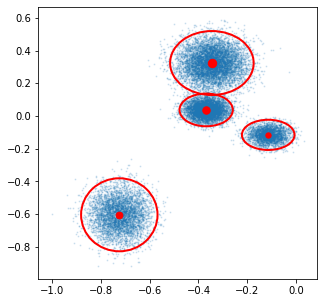

Log-likelihood:      1.5098695798367814
Using ground truth:  1.5096226451721961


In [8]:
from pycle.utils import plotGMM, loglikelihood_GMM
plotGMM(X,GMM)
print("Log-likelihood:     ",loglikelihood_GMM(GMM,X,robust = False))
print("Using ground truth: ", loglikelihood_GMM(GT_GMM,X,robust = False))